# Bayesian IRL Homework

First, we are going to walk you through some of the basics of this code. The goal of the project is to get some hands-on experience with MDPs and Bayesian IRL.

There will be questions throughout. Please prepare a pdf report with your answers to the questions.

First let's see how we can create an MDP. We will use some helper functions that come with the code.

In [4]:
import mdp
import mdp_utils
import bayesian_irl
import copy
import matplotlib.pyplot as plt

Let's make a simple MDP that is a 3x3 grid. This MDP looks like this, whre the dot indicates a terminal (absorbing) state. This state is implemented such that once you reach the terminal, there are no outgoing transitions.


![image of mdp](images/basic_grid_world.png)

The reward function is a linear combination of three binary features corresponding to the color of the state (blue, white, or red). The blue state has a true reward of +1, the white state has a true reward of 0 and the red feature has a true reward of -1. We can create this MDP using the following code and the FeatureMDP class from mdp.py


In [5]:
def simple_world():
    #four features, blue (true reward of +1), white (true reward of 0), red (true reward of -1), 
    
    b = [1,0,0]  #feature vector for blue colored state
    w = [0,1,0]  #feature vector for white colored state
    r = [0,0,1]  #feature vector for red colored state

    gamma = 0.9  #discount factor

    #create state features for a 2x2 grid (really just an array, but I'm formating it to look like the grid world)
    state_features = [b, r, w, 
                      w, r, w,
                      w, w, w]
    feature_weights = [+1.0, 0.0, -1.0] #red feature has weight -1 and blue feature has weight +1 and white feature has weight 0
    
    noise = 0.0 #no noise in transitions
    
    terminals = [0] #set state 0 to be a terminal (absorbing) state, in this implementation, that means there are no outgoing transitions
    
    env = mdp.FeatureMDP(3,3,terminals,feature_weights, state_features, gamma, noise)
    
    return env


We can create an instance of this world and look at the optimal policy.

In [6]:
env = simple_world()
opt_policy = mdp_utils.get_optimal_policy(env)
mdp_utils.visualize_policy(opt_policy, env)

.	<	v	
^	<	v	
^	<	<	


This shows a print out of a 3x3 grid with the optimal action denoted for each state (up : ^, down: v, left: <, right: >). As expected, the optimal policy is to avoid the red colored states and move to the terminal state in the top left.

We can also visualize the true reward function over the 3x3 mdp and the corresponding value function

In [7]:
print("reward function")
mdp_utils.print_array_as_grid(env.rewards, env)

print()
print("value function")

V = mdp_utils.value_iteration(env)
mdp_utils.print_array_as_grid(V, env)

reward function
1.00	-1.00	0.00	
0.00	-1.00	0.00	
0.00	0.00	0.00	

value function
1.00	-0.10	0.53	
0.90	-0.19	0.59	
0.81	0.73	0.66	


The value function should make intuitive sense. For example, starting in the top middle state (state 1), we get an immediate reward of -1. Then the optimal policy is to go left, whereupon we receive a reward of +1, discounted by gamm = 0.9, and we have reached the terminal state so there are no more transitions.

Thus, our expected reward starting from state 1 and following the optimal policy thereafter is
V[1] = 1 + 0.9 * (-1) = -0.10

## Running Bayesian IRL with demos 

We now want to run Bayesian IRL. We will give the following demonstration that starts at the top right state.
![image of mdp](images/basic_grid_world_good_demo.png)

In [8]:
#Give an optimal demo starting from the top right corner
#States are ordered left to right, top to bottom, the the state numbers are
'''
0 1 2
3 4 5
6 7 8
'''
#also actions are up:0, down:1, left:2, right:3
demo = [(2,1),(5,1),(8,2),(7,2),(6,0),(3,0),(0,0)]
#note we really don't need to demonstrate what to do in the terminal state since there are no transitions out of it

#let's visualize this using our simple commmand line viz tool
mdp_utils.visualize_trajectory(demo, env)

.	 	v	
^	 	v	
^	<	<	


We will now run Bayesian IRL with this demo to see what it learns. It may take a few seconds. After it completes running it will output an accept rate. We don't want this to be lower than 30% or higher than 70% (rough ball-park numbers). Too high and it means we aren't exploring enough, too low, and we aren't finding any good samples.

In [9]:
beta = 10.0       #assume near optimal demonstrator
num_steps = 1000  #number of steps to run MCMC
step_stdev = 0.1  #standard deviation for sampling proposals

birl = bayesian_irl.BIRL(env, demo, beta)

birl.run_mcmc(num_steps, step_stdev)

accept rate: 0.474


Let's visualize the MAP reward and corresponding optimal policy.

In [10]:
map_reward_weights = birl.get_map_solution()
print("MAP reward weights", map_reward_weights)
print("MAP reward function for mdp")
mdp_utils.visualize_feature_reward(map_reward_weights, env)

MAP reward weights [ 0.09872102 -0.21608226 -0.97137151]
MAP reward function for mdp
0.10	-0.97	-0.22	
-0.22	-0.97	-0.22	
-0.22	-0.22	-0.22	


In [11]:
# visualize the optimal policy for the learned reward function
env_learned = copy.deepcopy(env)
env_learned.set_rewards(map_reward_weights)
learned_pi = mdp_utils.get_optimal_policy(env_learned)

#text-based visualization of optimal policy
print("Learned policy from Bayesian IRL using MAP reward") 
mdp_utils.visualize_policy(learned_pi, env_learned)

Learned policy from Bayesian IRL using MAP reward
.	<	v	
^	<	v	
^	<	<	


As a reminder, here is the true optimal policy and true reward function.

In [12]:
print("True Reward Function")
mdp_utils.visualize_feature_reward(env.feature_weights, env)

print()

print("Optimal policy based on true reward")
mdp_utils.visualize_policy(opt_policy, env)

True Reward Function
1.00	-1.00	0.00	
0.00	-1.00	0.00	
0.00	0.00	0.00	

Optimal policy based on true reward
.	<	v	
^	<	v	
^	<	<	


### Question 1 (a)
Report the learned MAP reward and learned optimal policy from above. 

### Question 1 (b)
Is the learned reward the same as the true reward? Why or why not? 

### Question 1 (c) 
Does the learned reward make sense given the demonstrations?

### Question 1 (d)
If you continued to give demonstrations, would the MAP reward eventually converge to the true reward?

## Examining the posterior distribution returned by Bayesian IRL

We can look at the chain from MCMC to gain insights into what the agent has learned from demonstrations.

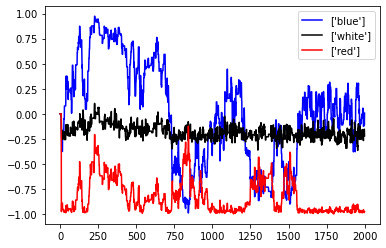

In [16]:
plt.plot(birl.chain[:,0], 'b', label=['blue'])
plt.plot(birl.chain[:,1], 'k', label=['white'])
plt.plot(birl.chain[:,2], 'r', label=['red'])
plt.legend()

To explore the variability in the posterior, let's run Bayesian IRL again using the same demo and plot the reward weights like above.

accept rate: 0.4905


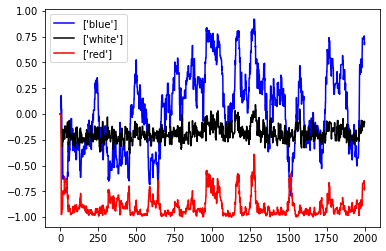

In [18]:
birl.run_mcmc(num_steps, step_stdev)
plt.plot(birl.chain[:,0], 'b', label=['blue'])
plt.plot(birl.chain[:,1], 'k', label=['white'])
plt.plot(birl.chain[:,2], 'r', label=['red'])
plt.legend()


### Question 2 (a)
Include an image of the above two plots in your answer (you should be able to just right click on them). Is there anything strange/wrong about the weight on the blue feature being negative? Explain your answer. What has Bayesian IRL learned about the relationship between the the white (black line in the plot) and red feature weights?

One of the main benefits of Bayesian IRL is that we can capture uncertainty over the reward function. We will now look at what happens when we have an ambiguous demonstration and how that affects our posterior distribution. We will give the following demonstration.
![image of mdp](images/basic_grid_world_ambiguous_demo.png)

In [49]:
#Give an optimal demo, but ambiguous demo, 
#Recall that states are ordered left to right, top to bottom, the the state numbers are
'''
0 1 2
3 4 5
6 7 8
'''
#also actions are up:0, down:1, left:2, right:3
ambiguous_demo = [(3,0)] #go up in state 3


#let's visualize this using our simple commmand line viz tool
mdp_utils.visualize_trajectory(ambiguous_demo, env)

 	 	 	
^	 	 	
 	 	 	


We will now run Bayesian IRL on this single state-action pair (this is another advantage of Bayesian IRL, it doesn't need full trajectories like MaxEnt IRL or the MaxMargin or Projection Algorithms)

In [57]:
beta = 10.0       #assume near optimal demonstrator
num_steps = 1000  #number of steps to run MCMC
step_stdev = 0.1  #standard deviation for sampling proposals
birl = bayesian_irl.BIRL(env, ambiguous_demo, beta)
birl.run_mcmc(num_steps, step_stdev)

accept rate: 0.937


You will probably have an accept rate that is too high. If so, increase the step_stdev until you get between 40-60% accepts. Note that there are more advanced versions of MCMC that will automatically tune step sizes, but here we're just using a plain vanilla version so you get to tune things :)

### Question 2 (b)
Why do you think a step size of 0.1 worked for the initial demo, but not for the ambiguous demo? (Hint, think about what a high accept rate means. Why is Bayesian IRL accepting so many more proposals now?) 

Let's now plot the weights found via MCMC for the ambiguous demonstration.

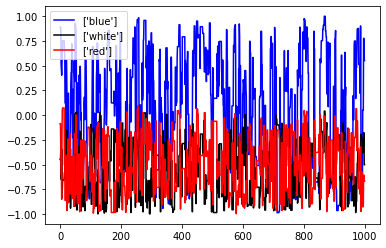

In [51]:
plt.plot(birl.chain[:,0], 'b', label=['blue'])
plt.plot(birl.chain[:,1], 'k', label=['white'])
plt.plot(birl.chain[:,2], 'r', label=['red'])
plt.legend()

Let's zoom in on just the last 100 samples


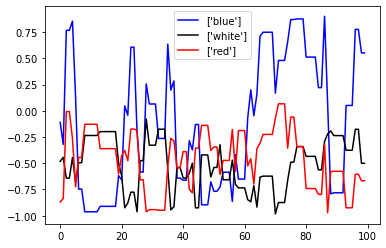

In [52]:
plt.plot(birl.chain[-100:,0], 'b', label=['blue'])
plt.plot(birl.chain[-100:,1], 'k', label=['white'])
plt.plot(birl.chain[-100:,2], 'r', label=['red'])
plt.legend()

### Question 2(c)
Include images of the above two plots as part of your answer. Do you notice anything different about the posterior distribution? Why or why not? How would you explain the difference, especially regarding the relative posterior weights on the blue, red, and white features?

Let's look at the optimal policy for the MAP reward

In [53]:
map_reward_weights = birl.get_map_solution()
print("MAP reward weights", map_reward_weights)
print("MAP reward function for mdp")
mdp_utils.visualize_feature_reward(map_reward_weights, env)

# visualize the optimal policy for the learned reward function
env_learned = copy.deepcopy(env)
env_learned.set_rewards(map_reward_weights)
learned_pi = mdp_utils.get_optimal_policy(env_learned)

#text-based visualization of optimal policy
print("Learned policy from Bayesian IRL using MAP reward") 
mdp_utils.visualize_policy(learned_pi, env_learned)

MAP reward weights [ 0.11765292 -0.85718986 -0.50138142]
MAP reward function for mdp
0.12	-0.50	-0.86	
-0.86	-0.50	-0.86	
-0.86	-0.86	-0.86	
Learned policy from Bayesian IRL using MAP reward
.	<	<	
^	^	<	
^	^	^	


### Question 2(d)
Copy and past the output of the above cell as part of your answer. Did Bayesian IRL learn the right reward function and corresponding policy? Why or why not?

### Question 2(e)
How might you use the posterior distribution to actively select a state from which to get another demonstration that would reduce ambiguity over the true reward function?

## Succinct Demonstration

Finally, we will give another demo consisting of a single state-action pair, but this time we will give the following demo
![image of mdp](images/basic_grid_world_minimal_demo.png)

Pause for a second and try to reason about whether this demonstration is enough to learn the optimal policy.

Let's run Bayesian IRL on this demo and see what happens. Tune the step size if needed.

In [62]:
minimal_demo = [(2,1)] #go down in state 2
beta = 10.0       #assume near optimal demonstrator
num_steps = 1000  #number of steps to run MCMC
step_stdev = 0.9  #standard deviation for sampling proposals
birl = bayesian_irl.BIRL(env, minimal_demo, beta)
birl.run_mcmc(num_steps, step_stdev)

accept rate: 0.667


In [63]:
map_reward_weights = birl.get_map_solution()
print("MAP reward weights", map_reward_weights)
print("MAP reward function for mdp")
mdp_utils.visualize_feature_reward(map_reward_weights, env)

# visualize the optimal policy for the learned reward function
env_learned = copy.deepcopy(env)
env_learned.set_rewards(map_reward_weights)
learned_pi = mdp_utils.get_optimal_policy(env_learned)

#text-based visualization of optimal policy
print("Learned policy from Bayesian IRL using MAP reward") 
mdp_utils.visualize_policy(learned_pi, env_learned)

MAP reward weights [ 0.0346526  -0.1845603  -0.98221011]
MAP reward function for mdp
0.03	-0.98	-0.18	
-0.18	-0.98	-0.18	
-0.18	-0.18	-0.18	
Learned policy from Bayesian IRL using MAP reward
.	<	v	
^	<	v	
^	<	<	


### Question 3
Similar to the previous demo, this demo only consists of a single state-action pair. Did Bayesian IRL learn a reward function that leads to the desired behavior? Explain why or why not. What is different about this state-action pair compared to the previous one?